In [1]:
import warnings
warnings.filterwarnings('ignore')

# PINN investigation

## Vanilla PINN for non chaotic parameters 

In [2]:
# Imports
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

import pinn
import neural_networks as nns
import helper_functions as hf
import pinn_helper_functions as phf

### Vanilla PINN configuration

In [3]:
# ──────────────── Global configuration ────────────────
# Lorenz system parameter
A = 10
B = 0.5
C = 8/3

INITIAL_CONDITIONS = np.array([1.0, 1.0, 1.0], dtype=np.float32)

# PINN architecture
HIDDEN_LAYER = 6
NEURONS_PER_LAYER = 30
ACTIVATION_FUNCTION = tf.keras.activations.silu # NOTE: Silu equals swish activation function
WEIGHT_INITIALIZATION = tf.keras.initializers.GlorotUniform

# Hyperparameters for training
LEARNING_RATE = 0.01
DECAY_RATE = 0.09
OPTIMIZER = tf.keras.optimizers.Adam
EPOCHS = 5000 #25000
COLLOCATION_POINTS = 1024
ALPHA_DATA = 0.5

# Domain
t_min, t_max = 0.0, 15.0

In [4]:
# Create RK-45 reference solution
t_eval, sol_rk45 = hf.ref_solution(A, B, C, t_min, t_max, INITIAL_CONDITIONS)

## PINN Vergleich gegen Vanilla NN und Vanilla NN mit L2-Regulierung

### Neuronale Netze trainiert mit verrauschten Daten

In [31]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=1000,
    decay_rate=DECAY_RATE)

# Standard NN und NN mit L2-Regulierung erstellen
nn_model = nns.build_standard_nn(HIDDEN_LAYER, NEURONS_PER_LAYER, ACTIVATION_FUNCTION, WEIGHT_INITIALIZATION)
nn_model.compile(optimizer=OPTIMIZER(learning_rate=lr_schedule, decay=DECAY_RATE,), loss='mse')

nn_l2_model = nns.build_l2_regularized_nn(HIDDEN_LAYER, NEURONS_PER_LAYER, ACTIVATION_FUNCTION, WEIGHT_INITIALIZATION)
nn_l2_model.compile(optimizer=OPTIMIZER(learning_rate=lr_schedule, decay=DECAY_RATE), loss='mse')

# Vanilla PINN mit Normalisierung und data loss erstellen
pinn_model = phf.build_pinn_network(HIDDEN_LAYER, NEURONS_PER_LAYER, ACTIVATION_FUNCTION, WEIGHT_INITIALIZATION)

In [32]:
# Verrauschte Daten generieren
t_eval, sol = hf.ref_solution(A, B, C, t_min, t_max, INITIAL_CONDITIONS)
t_data, y_data = hf.generate_noisy_data(sol, t_min, t_max, noise_factor=0.3)

In [13]:
# Modelle auf verrauschten Daten trainieren
# nn_model.fit(t_data, y_data, epochs=EPOCHS)
nn_model.fit(t_data, y_data, epochs=EPOCHS, verbose=0)

nn_l2_model.fit(t_data, y_data, epochs=EPOCHS, verbose=0)
pinn.train(
    pinn_model,
    t_initial=t_min,
    initial_conditions=INITIAL_CONDITIONS,
    A=A, B=B, C=C,
    t_min=t_min, t_max=t_max,
    collocation_points=COLLOCATION_POINTS,
    alpha=ALPHA_DATA,
    learning_rate=LEARNING_RATE,
    decay_rate=DECAY_RATE,
    epochs=EPOCHS,
    optimizer_class=OPTIMIZER,
    normalize_input=False,
    data_active=True,
    t_data=t_data,
    y_data=y_data
)

Training started...
Epoch     0 | Loss: 8.7861e-02 | Data/IC-Loss: 1.3342e-01 | Physics-Loss: 4.2306e-02
Epoch  1000 | Loss: 4.6691e-02 | Data/IC-Loss: 9.1888e-02 | Physics-Loss: 1.4935e-03
Epoch  2000 | Loss: 4.6239e-02 | Data/IC-Loss: 9.1648e-02 | Physics-Loss: 8.2876e-04
Epoch  3000 | Loss: 4.6124e-02 | Data/IC-Loss: 9.1636e-02 | Physics-Loss: 6.1261e-04
Epoch  4000 | Loss: 4.6191e-02 | Data/IC-Loss: 9.1637e-02 | Physics-Loss: 7.4510e-04
Epoch  4999 | Loss: 4.6274e-02 | Data/IC-Loss: 9.1636e-02 | Physics-Loss: 9.1156e-04
Training finished!


In [14]:
# nn_model.save('./saved_models/Standard_NN_verrauscht.keras')

In [33]:
# Modellergebnisse vorhersagen und plotten
y_nn, phy_loss = pinn.pinn_predict(nn_model, t_eval, t_min, t_max, normalize_input=False, A=A, B=B, C=C)
y_l2_nn, phy_loss = pinn.pinn_predict(nn_l2_model, t_eval, t_min, t_max, normalize_input=False, A=A, B=B, C=C)
y_pinn, phy_loss = pinn.pinn_predict(pinn_model, t_eval, t_min, t_max, normalize_input=False, A=A, B=B, C=C)

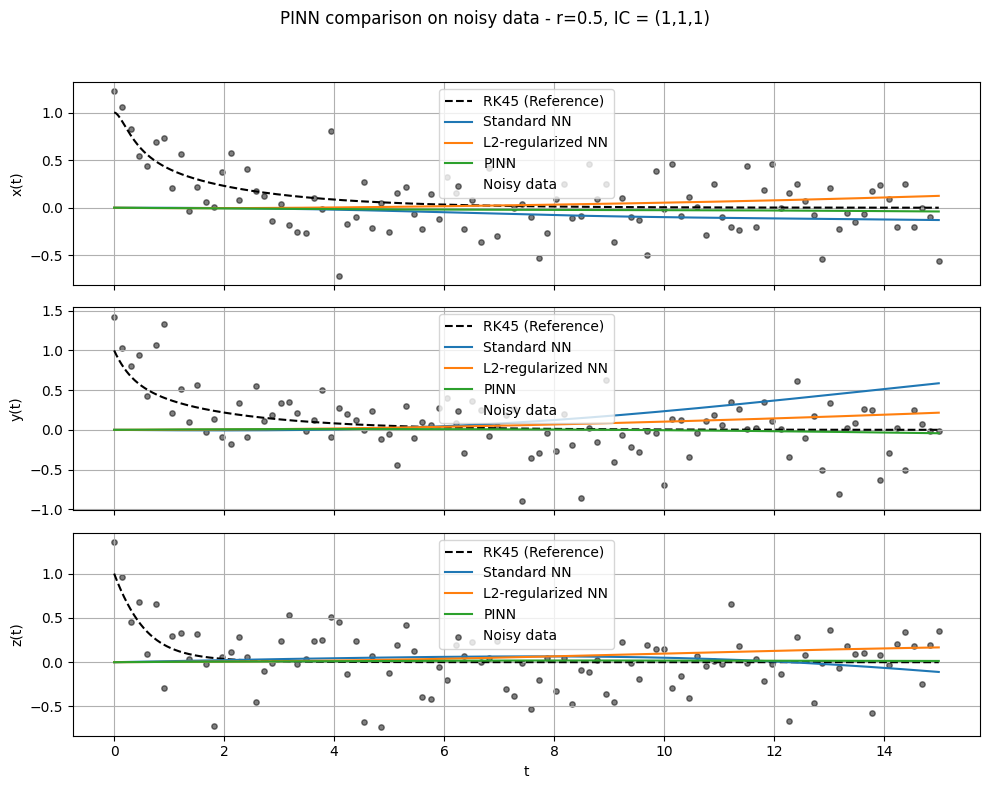

In [34]:
t_plot = t_eval.flatten()

# Noisy Daten vorbereiten
t_data_np = t_data.numpy().flatten()
y_data_np = y_data.numpy()

labels = ['x(t)', 'y(t)', 'z(t)']
models = ['Standard NN', 'L2-regularized NN', 'PINN']
predictions = [y_nn, y_l2_nn, y_pinn]

fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

for i in range(3):  # Für x, y, z
    # Referenzlösung (RK45) plotten
    axs[i].plot(t_eval, sol_rk45.y[i], 'k--', label="RK45 (Reference)")

    # Modellvorhersagen plotten
    for j, y in enumerate(predictions):
        axs[i].plot(t_plot, y[:, i], label=models[j])

    # Noisy Daten plotten
    axs[i].scatter(t_data_np, y_data_np[:, i], color='black', s=15, alpha=0.5, label='Noisy data')

    axs[i].set_ylabel(labels[i])
    axs[i].legend()
    axs[i].grid(True)

axs[-1].set_xlabel('t')
plt.suptitle("PINN comparison on noisy data - r=0.5, IC = (1,1,1)")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


### Neuronale Netze trainiert mit unvollständigen Daten

In [17]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=1000,
    decay_rate=DECAY_RATE)

# Standard NN und NN mit L2-Regulierung erstellen
nn_model = nns.build_standard_nn(HIDDEN_LAYER, NEURONS_PER_LAYER, ACTIVATION_FUNCTION, WEIGHT_INITIALIZATION)
nn_model.compile(optimizer=OPTIMIZER(learning_rate=lr_schedule, decay=DECAY_RATE,), loss='mse')

nn_l2_model = nns.build_l2_regularized_nn(HIDDEN_LAYER, NEURONS_PER_LAYER, ACTIVATION_FUNCTION, WEIGHT_INITIALIZATION)
nn_l2_model.compile(optimizer=OPTIMIZER(learning_rate=lr_schedule, decay=DECAY_RATE), loss='mse')

# Vanilla PINN mit Normalisierung und data loss erstellen
pinn_model = phf.build_pinn_network(HIDDEN_LAYER, NEURONS_PER_LAYER, ACTIVATION_FUNCTION, WEIGHT_INITIALIZATION)

In [18]:
# Unvollständige Daten generieren
t_eval, sol = hf.ref_solution(A, B, C, t_min, t_max, INITIAL_CONDITIONS)
t_data, y_data = hf.generate_noisy_data(sol, t_min, t_max, noise_factor=0.3, n_data=100)
t_data_gap, y_data_gap = hf.generate_noisy_data_with_gap(sol, t_min, t_max, 4, 7, 0.5)

In [19]:
# Modelle auf verrauschten Daten trainieren
nn_model.fit(t_data_gap, y_data_gap, epochs=EPOCHS, batch_size=32, verbose=0) # batch size so training isn't done on all of the collocation points


In [20]:
nn_l2_model.fit(t_data_gap, y_data_gap, epochs=EPOCHS, batch_size=32, verbose=0) # batch size so training isn't done on all of the collocation points


In [21]:
pinn.train(
    pinn_model,
    t_initial=t_min,
    initial_conditions=INITIAL_CONDITIONS,
    A=A, B=B, C=C,
    t_min=t_min, t_max=t_max,
    collocation_points=COLLOCATION_POINTS,
    alpha=ALPHA_DATA,
    learning_rate=LEARNING_RATE,
    decay_rate=DECAY_RATE,
    epochs=EPOCHS,
    optimizer_class=OPTIMIZER,
    normalize_input=False,
    data_active=True,
    t_data=t_data_gap,
    y_data=y_data_gap
)

Training started...
Epoch     0 | Loss: 2.7232e-01 | Data/IC-Loss: 3.2512e-01 | Physics-Loss: 2.1951e-01
Epoch  1000 | Loss: 1.2896e-01 | Data/IC-Loss: 2.5664e-01 | Physics-Loss: 1.2798e-03
Epoch  2000 | Loss: 1.2903e-01 | Data/IC-Loss: 2.5640e-01 | Physics-Loss: 1.6529e-03
Epoch  3000 | Loss: 1.2881e-01 | Data/IC-Loss: 2.5633e-01 | Physics-Loss: 1.2827e-03
Epoch  4000 | Loss: 1.2944e-01 | Data/IC-Loss: 2.5633e-01 | Physics-Loss: 2.5496e-03
Epoch  4999 | Loss: 1.2879e-01 | Data/IC-Loss: 2.5633e-01 | Physics-Loss: 1.2555e-03
Training finished!


In [22]:
# Modellergebnisse vorhersagen und plotten
y_nn, phy_loss = pinn.pinn_predict(nn_model, t_eval, t_min, t_max, normalize_input=False, A=A, B=B, C=C)
y_l2_nn, phy_loss = pinn.pinn_predict(nn_l2_model, t_eval, t_min, t_max, normalize_input=False, A=A, B=B, C=C)
y_pinn, phy_loss = pinn.pinn_predict(pinn_model, t_eval, t_min, t_max, normalize_input=False, A=A, B=B, C=C)

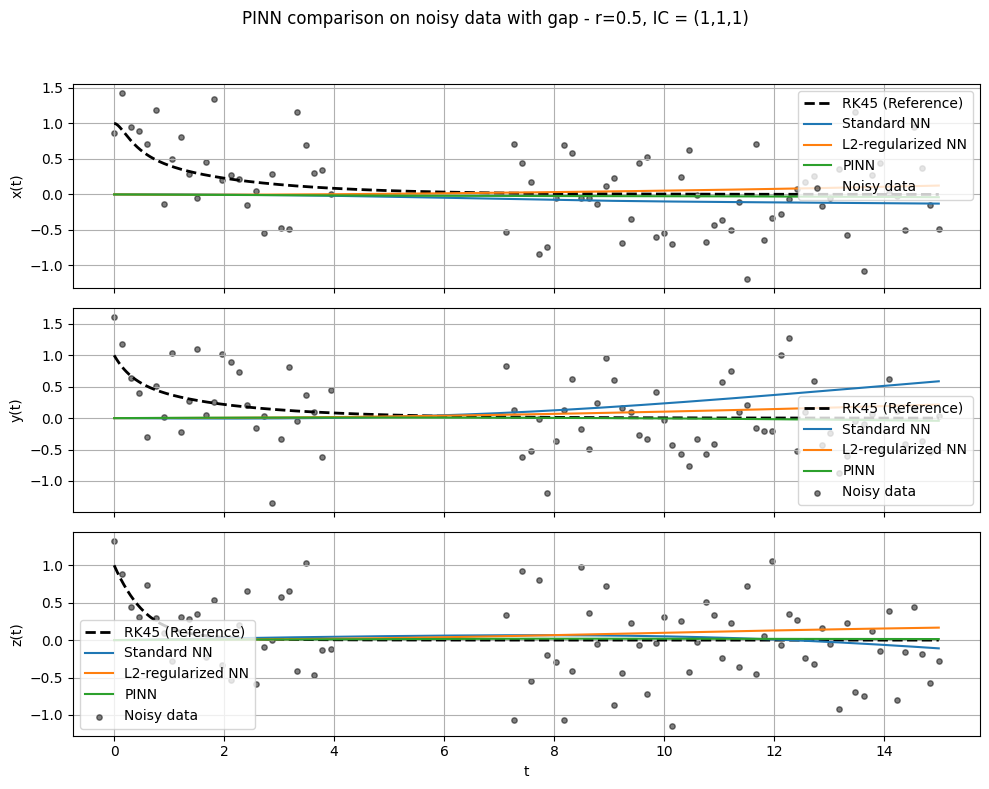

In [35]:
t_plot = t_eval.flatten()

# Noisy Daten mit Lücke vorbereiten
t_data_np = t_data_gap.numpy().flatten()
y_data_np = y_data_gap.numpy()

labels = ['x(t)', 'y(t)', 'z(t)']
models = ['Standard NN', 'L2-regularized NN', 'PINN']
predictions = [y_nn, y_l2_nn, y_pinn]

fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

for i in range(3):  # Für x, y, z
    # Referenzlösung (RK45) hinzufügen
    axs[i].plot(t_eval, sol_rk45.y[i], 'k--', linewidth=2, label="RK45 (Reference)")

    # Modellvorhersagen plotten
    for j, y in enumerate(predictions):
        axs[i].plot(t_plot, y[:, i], label=models[j])

    # Noisy Daten mit Lücke plotten
    axs[i].scatter(t_data_np, y_data_np[:, i], color='black', s=15, alpha=0.5, label='Noisy data')

    axs[i].set_ylabel(labels[i])
    axs[i].legend()
    axs[i].grid(True)

axs[-1].set_xlabel('t')
plt.suptitle("PINN comparison on noisy data with gap - r=0.5, IC = (1,1,1)")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


### Neuronale Netze trainiert mit teilweise vorhandenen Daten

In [24]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=1000,
    decay_rate=DECAY_RATE)

# Standard NN und NN mit L2-Regulierung erstellen
nn_model = nns.build_standard_nn(HIDDEN_LAYER, NEURONS_PER_LAYER, ACTIVATION_FUNCTION, WEIGHT_INITIALIZATION)
nn_model.compile(optimizer=OPTIMIZER(learning_rate=lr_schedule, decay=DECAY_RATE,), loss='mse')

nn_l2_model = nns.build_l2_regularized_nn(HIDDEN_LAYER, NEURONS_PER_LAYER, ACTIVATION_FUNCTION, WEIGHT_INITIALIZATION)
nn_l2_model.compile(optimizer=OPTIMIZER(learning_rate=lr_schedule, decay=DECAY_RATE), loss='mse')

# Vanilla PINN mit Normalisierung und data loss erstellen
pinn_model = phf.build_pinn_network(HIDDEN_LAYER, NEURONS_PER_LAYER, ACTIVATION_FUNCTION, WEIGHT_INITIALIZATION)

In [25]:
# Teilweise vorhandene Daten generieren
t_eval, sol = hf.ref_solution(A, B, C, t_min, t_max, INITIAL_CONDITIONS)
t_data, y_data = hf.generate_noisy_data(sol, t_min, t_max, noise_factor=0.3)
y_data_part = hf.generate_partial_noisy_data(y_data, column='x')

Test


In [26]:
# Modelle auf teilweise vorhandenen Daten trainieren
nn_model.fit(t_data, y_data_part, epochs=EPOCHS, batch_size=32, verbose=0) # batch size so training isn't done on all of the collocation points


In [27]:
nn_l2_model.fit(t_data, y_data_part, epochs=EPOCHS, batch_size=32, verbose=0) # batch size so training isn't done on all of the collocation points


In [28]:
pinn.train(
    pinn_model,
    t_initial=t_min,
    initial_conditions=INITIAL_CONDITIONS,
    A=A, B=B, C=C,
    t_min=t_min, t_max=t_max,
    collocation_points=COLLOCATION_POINTS,
    alpha=ALPHA_DATA,
    learning_rate=LEARNING_RATE,
    decay_rate=DECAY_RATE,
    epochs=EPOCHS,
    optimizer_class=OPTIMIZER,
    normalize_input=False,
    data_active=True,
    t_data=t_data,
    y_data=y_data_part
)

Training started...
Epoch     0 | Loss: 1.0613e-01 | Data/IC-Loss: 1.4079e-01 | Physics-Loss: 7.1482e-02
Epoch  1000 | Loss: 5.7753e-02 | Data/IC-Loss: 1.1445e-01 | Physics-Loss: 1.0560e-03
Epoch  2000 | Loss: 5.6774e-02 | Data/IC-Loss: 1.1234e-01 | Physics-Loss: 1.2099e-03
Epoch  3000 | Loss: 5.6689e-02 | Data/IC-Loss: 1.1211e-01 | Physics-Loss: 1.2646e-03
Epoch  4000 | Loss: 5.6721e-02 | Data/IC-Loss: 1.1209e-01 | Physics-Loss: 1.3534e-03
Epoch  4999 | Loss: 5.6699e-02 | Data/IC-Loss: 1.1209e-01 | Physics-Loss: 1.3115e-03
Training finished!


In [29]:
# Modellergebnisse vorhersagen und plotten
y_nn, phy_loss = pinn.pinn_predict(nn_model, t_eval, t_min, t_max, normalize_input=False, A=A, B=B, C=C)
y_l2_nn, phy_loss = pinn.pinn_predict(nn_l2_model, t_eval, t_min, t_max, normalize_input=False, A=A, B=B, C=C)
y_pinn, phy_loss = pinn.pinn_predict(pinn_model, t_eval, t_min, t_max, normalize_input=False, A=A, B=B, C=C)

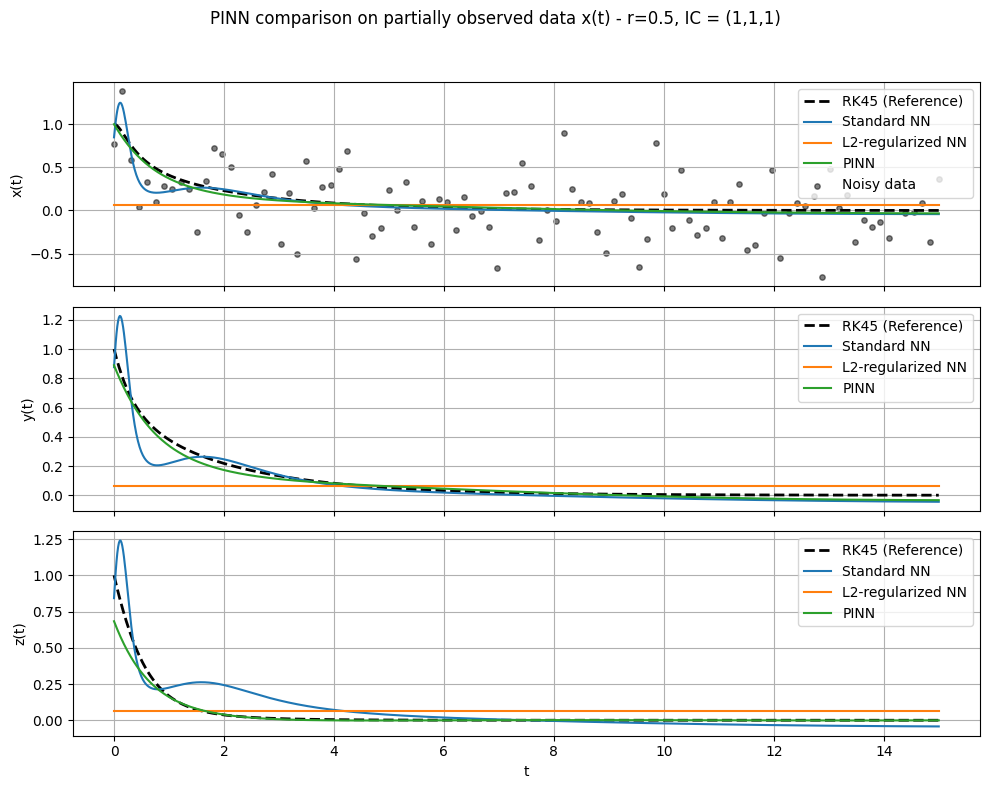

In [30]:
# Falls noch nicht vorhanden – Noisy Daten vorbereiten
t_data_np = t_data.numpy().flatten()
y_data_np = y_data.numpy()

# Vorhersagen
t_plot = t_eval.flatten()
predictions = [y_nn, y_l2_nn, y_pinn]
models = ['Standard NN', 'L2-regularized NN', 'PINN']
labels = ['x(t)', 'y(t)', 'z(t)']

# Plot
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

for i in range(3):  # Für x, y, z
    axs[i].plot(t_eval, sol_rk45.y[i], 'k--', linewidth=2, label="RK45 (Reference)")

    for j, y in enumerate(predictions):
        axs[i].plot(t_plot, y[:, i], label=models[j])

    # Noisy data nur für x(t)
    if i == 0:
        axs[i].scatter(t_data_np, y_data_np[:, 0], color='black', s=15, alpha=0.5, label='Noisy data')

    axs[i].set_ylabel(labels[i])
    axs[i].legend(loc='upper right')
    axs[i].grid(True)

axs[-1].set_xlabel('t')
plt.suptitle("PINN comparison on partially observed data x(t) - r=0.5, IC = (1,1,1)")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
